In [4]:
from IPython.display import clear_output
import time
from omegaconf import OmegaConf
import yaml
from taming.models.bert_transformer import BertTransformer
import torch
import yaml
from taming.models.cond_transformer import Net2NetTransformer
import torch
import numpy as np
from scipy import ndimage
import torchvision

##LOADING BERT
config_path = "./logs/2021-10-14T16-32-28_ffhq_transformer_bert_2D/configs/2021-10-14T16-32-28-project.yaml"
config = OmegaConf.load(config_path)
model = BertTransformer(**config.model.params)
ckpt_path = "./logs/2021-10-14T16-32-28_ffhq_transformer_bert_2D/checkpoints/epoch=000019.ckpt"

sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)
model.cuda().eval()
torch.set_grad_enabled(True)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-10-14T16-32-28_ffhq_transformer_bert_2D/checkpoints/vqgan.ckpt
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 0 as a sos token.


## Load a dummy image

In [5]:
from PIL import Image
import numpy as np
img_path = "/data/ffhq/00306.png.png"
img = Image.open(img_path)
img = np.array(img)
img = torch.tensor(img.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)
img = img/127.5-1
img = torch.nn.functional.interpolate(img, size=(256))
print(img.shape)

def show_segmentation(s):
    s = s.detach().cpu().numpy().transpose(0,2,3,1)[0,:,:,None,:]
    s = s[...,0,:]
    s = s * 255
    s = s.clip(0,255).astype(np.uint8)
    s = Image.fromarray(s)
    display(s)
    
def show_image(s):
    s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
    s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
    s = Image.fromarray(s)
    display(s)

z_code, z_indices = model.encode_to_z(img)
print("z_code", z_code.shape, z_code.dtype)
print("z_indices", z_indices.shape, z_indices.dtype)
assert z_code.shape[2]*z_code.shape[3] == z_indices.shape[1]
img_rec = model.first_stage_model.decode(z_code)

#Show a random image!!
codebook_size = config.model.params.first_stage_config.params.embed_dim
z_indices = torch.randint(codebook_size, z_indices.shape, device=model.device)
x_sample = model.decode_to_img(z_indices, z_code.shape)
show_image(img)
show_image(img_rec)
show_image(x_sample)

FileNotFoundError: [Errno 2] No such file or directory: '/data/ffhq/00306.png.png'

## Define utils functions

In [7]:
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import torchvision

def show(img):
    npimg = img.cpu().numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plt_save_image(images, textfile):
    plt.clf()
    width = 5*len(images)
    fig=plt.figure(figsize=(width, 10))
    for i in range(len(images)):
        ax = fig.add_subplot(1, len(images), i+1)
        ax.set_axis_off()
        show(images[i])
        
        if i ==0:
            autoAxis = ax.axis()
            rec = plt.Rectangle((autoAxis[0], autoAxis[2]),(autoAxis[1]-autoAxis[0])+1,(autoAxis[3]-autoAxis[2])+0.4, \
                                fill=False, lw=2, color='green')
            rec = ax.add_patch(rec)
            rec.set_clip_on(False)
        
    plt.tight_layout()
    plt.savefig('images/'+textfile+'.jpg', bbox_inches="tight")

def get_probs_si(logits, target, temperature, wasserstein=False):
    logits = logits[:, 1:,]
    target = target[:, 1:]
    logits = logits.squeeze(0)
    target = target.squeeze(0)
    probs = torch.nn.functional.softmax(logits, dim=1)    
    probs_si = torch.diag(-probs[:,target])
    probs_si_np = probs_si.detach().cpu().numpy()
    probs_si_np = probs_si_np/np.amax(np.abs(probs_si_np))
    
    #print(wasserstein, probs_si_np)
    probs_si_np /= temperature
    probs_si_np = np.exp(probs_si_np)/np.sum(np.exp(probs_si_np))
    return probs_si_np

def plt_save_image_and_heatmap(image, probs_si, image2=None, textfile=None, titles=None):
    plt.clf()
    fig=plt.figure(figsize=(8, 8))
    if image2 is not None:
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.set_axis_off()
        show(image)
        ax2 = fig.add_subplot(1, 3, 2)
        plt.imshow(probs_si, cmap='coolwarm', interpolation='nearest')
        ax2.set_axis_off()    
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_axis_off()
        show(image2)
        if titles is not None:
            ax1.set_title(titles[0])
            ax2.set_title(titles[1])
            ax3.set_title(titles[2])
    else:
        ax = fig.add_subplot(1, 2, 1)
        ax.set_axis_off()
        show(image)
        ax = fig.add_subplot(1, 2, 2)
        plt.imshow(probs_si, cmap='coolwarm', interpolation='nearest')
        ax.set_axis_off()
        if titles is not None:
            ax1.set_title(titles[0])
            ax2.set_title(titles[1])
            
    plt.tight_layout()
    plt.show()
    plt.savefig(textfile+".jpg")


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
    
replace_grad = ReplaceGrad.apply

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    return indices

class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None

clamp_with_grad = ClampWithGrad.apply    

def get_mask_and_sampled_tokens(img, mask):    
    mask_interpolation = torch.nn.functional.interpolate(mask, (16), mode='bilinear')[:,0,:]
    mask_interpolation = (mask_interpolation > 0.1).float()
    mask_interpolation_np = mask_interpolation.cpu().numpy()

    if dilation_sampling>0:
        diff_mask = 1-ndimage.binary_dilation(1-mask_interpolation_np, iterations=dilation_sampling).astype(mask_interpolation_np.dtype)#.flatten()
    elif dilation_sampling<0:
        diff_mask = ndimage.binary_dilation(mask_interpolation_np, iterations=-dilation_sampling).astype(mask_interpolation_np.dtype)
    else:
        diff_mask = mask_interpolation_np

    unsampled_tokens = np.where(diff_mask[0].flatten()==1)[0]
    sampled_tokens = np.where(diff_mask[0].flatten()==0)[0]

    if dilation_masking>0:
        mask_interpolation_np = 1-ndimage.binary_dilation(1-mask_interpolation_np, iterations=dilation_masking).astype(mask_interpolation_np.dtype)#.flatten()
    elif dilation_masking<0:
        mask_interpolation_np = ndimage.binary_dilation(mask_interpolation_np, iterations=-dilation_masking).astype(mask_interpolation_np.dtype)
    mask_interpolation = torch.from_numpy(mask_interpolation_np).to(model.device)
    mask_interpolation = mask_interpolation.view(mask_interpolation.shape[0],-1)
    return mask_interpolation, mask_interpolation_np, diff_mask, sampled_tokens

def img_tensor(filepath,mask=False):
    img = Image.open(filepath).convert('RGB')
    img_np = np.array(img)
    #segmentation = np.eye(182)[segmentation]
    img = torch.tensor(img_np.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)
    if mask:
        img = img/255
    else:
        img = img/127.5-1
    img = torch.nn.functional.interpolate(img, size=(256))
    return img, img_np

def random_mask(im, num_masks):
    im = np.array(im)
    im.setflags(write=1)
    img_height, img_width = im.shape[0], im.shape[1]
    size = int(0.25*img_height)
    im[:] = 1.
    for i in range(num_masks):
        x_corner = np.random.randint(0, img_height-size-1)
        y_corner = np.random.randint(0, img_width-size-1)
        im[x_corner:x_corner+size,y_corner:y_corner+size,:] = 0.4

    im = torch.tensor(im.transpose(2,0,1)).to(dtype=torch.float32, device=model.device)
    im = torch.nn.functional.interpolate(im.unsqueeze(0), size=(256))
    im = im.squeeze(0)
    return im

## Improve image with BERT

In [19]:
## TO DO: check different tokens --> re-sample only the different tokens. 
from torch.autograd import Variable
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
start_t = time.time()

val_path = "/data/ffhqsubvalidation.txt"
with open(val_path) as f:
    img_path = f.readlines()

def image_completion_with_BERT(idx):
    dilation_masking = 0
    dilation_sampling = 1
    progressive_ordering = False

    img_path_original = "/data/ffhq/" + img_path[idx].replace('\n','')
    img, img_np = img_tensor(img_path_original)
    mask = random_mask(img_np, num_masks=1).unsqueeze(0)
    #mask = (mask>0.5).float()

    img = img*mask + (1-mask) * (torch.zeros_like(img))
    show_image(mask)
    show_image(img)
    img = img.repeat(1,1,1,1)
    mask = mask.repeat(1,1,1,1)

    mask_interpolation, mask_interpolation_np, diff_mask, sampled_tokens = \
        get_mask_and_sampled_tokens(img, mask)

    progressive_ordering = True
    random_ordering = False
    blending = False
    gaussian_smoothing = True
    erase_mask_influence = True
    mask_inference_token = False
    select_min = False
    masked_attention = False
    attention_mask = None
    mask_collage = True

    update_every = 32
    nb_epoch = 2
    multiple_change = 1
    nb_updates_per_epoch = int(sampled_tokens.shape[0] / multiple_change) + 1
    collage_every = int(nb_updates_per_epoch/5)
    temperature = 1
    top_k = 100
    temperature_position = 1.

    z_code, z_indices = model.encode_to_z(img)
    _, c_indices = model.encode_to_c(img)

    if progressive_ordering:
        sampled_tokens_progressive = []
        prev_diff_mask = diff_mask
        while True:
            diff_mask = ndimage.binary_dilation(diff_mask, iterations=1).astype(mask_interpolation_np.dtype)
            dilated_area = diff_mask-prev_diff_mask
            prev_diff_mask = diff_mask
            sampled_tokens_i = np.where(dilated_area[0].flatten()==1)[0]
            for st_i in sampled_tokens_i:
                sampled_tokens_progressive.append(st_i )
            if np.sum(1-diff_mask) == 0:
                break
        sampled_tokens = np.array(sampled_tokens_progressive)

    if gaussian_smoothing:
        sigma = 10
        kernel_size = 5
        blurrer = torchvision.transforms.GaussianBlur(kernel_size=(kernel_size,kernel_size), sigma=(sigma,sigma))
        mask = mask.cpu().numpy()
        mask = 1-ndimage.binary_dilation(1-mask, iterations=int(kernel_size/2)).astype(mask_interpolation_np.dtype)
        mask = torch.from_numpy(mask).to(device=model.device)
        mask_gaussian = 1-blurrer(1-mask)
        mask = torch.min(mask_gaussian, mask)

    if blending:
        mask_np = 1-mask[0][0].detach().cpu().numpy()
        lap_mat = get_lap_matrix(mask_np)

    if erase_mask_influence:
        mask_interpolation = mask_interpolation.view(mask_interpolation.shape[0],-1)
        r_indices = torch.randint_like(z_indices, 0, model.transformer.config.vocab_size)
        if model.mask_token:
            idx_disp = r_indices.reshape(z_code.shape[0],z_code.shape[2],z_code.shape[3])
            r_indices = 0 * r_indices + model.transformer.config.vocab_size
        z_indices = z_indices.long()
        z_indices = mask_interpolation.long()*z_indices + (1-mask_interpolation).long()*r_indices

    idx = z_indices.reshape(z_code.shape[0],z_code.shape[2],z_code.shape[3])
    r_indices = r_indices.reshape(z_code.shape[0],z_code.shape[2],z_code.shape[3])

    for e in range(nb_epoch):
        if random_ordering:
            np.random.shuffle(sampled_tokens)

        for u in range(nb_updates_per_epoch):        
            if mask_collage and u%collage_every == 0 and (nb_updates_per_epoch - u >= collage_every):
                print("Collage here, step:",u)
                check_mask_token = (idx ==  model.transformer.config.vocab_size)
                #if torch.sum(check_mask_token) == 0:
                if model.mask_token:
                    idx_disp = torch.where(check_mask_token, idx_disp, idx)
                    xz = model.decode_to_img(idx_disp, z_code.shape)
                else:
                    xz = model.decode_to_img(idx, z_code.shape)

                if blending:
                    xz_mask = get_blending(img[0], xz[0], mask_np).to(model.device)

                    img = img*mask + (1-mask)*(xz)
                    img = get_blending(img[0], xz[0], mask_np).cuda()
                else:
                    xz_mask = img * mask + (1-mask) * (xz)

                z_code,z_indices = model.encode_to_z(xz_mask)
                z_indices = z_indices.reshape(z_code.shape[0],z_code.shape[2],z_code.shape[3])
                if model.mask_token:
                    print(check_mask_token.shape,r_indices.shape,z_indices.shape)
                    z_indices = torch.where(check_mask_token, r_indices, z_indices)
                z_indices = z_indices.reshape(z_indices.shape[0],-1)
                idx = z_indices

            k = e*nb_updates_per_epoch + u
            z_indices = idx.reshape(idx.shape[0],-1)

            if mask_inference_token:
                for m in range(multiple_change):
                    jm = (k*multiple_change+m)%(sampled_tokens.shape[0])
                    idx_change = sampled_tokens[jm]
                    if model.mask_token:
                        z_indices[:, idx_change] = model.transformer.config.vocab_size
                    else:
                        z_indices[:, idx_change] = torch.randint(model.transformer.config.vocab_size,(1,))

            cz_indices = torch.cat((c_indices, z_indices), dim=1)
            logits, _ = model.transformer.forward_with_mask(cz_indices[:, :],mask=attention_mask)
            logits = logits[:,c_indices.shape[1]:,]
            logits = logits/temperature
            probs = torch.nn.functional.softmax(logits, dim=-1) 

            idx = idx.reshape(idx.shape[0],-1)
            if select_min:
                probs_si = get_probs_si(probs, cz_indices[:,cpatch.shape[1]:], temperature=temperature_position)
                for pos in unsampled_tokens:
                    probs_si[0,pos] = 1e-10
                ix_positions = torch.multinomial(probs_si, num_samples=multiple_change)
                for m in range(ix_positions.shape[0]):
                    for n in range(ix_positions.shape[1]):
                        idx_change = ix_positions[m,n]
                        logits_s_idx = logits[m,idx_change,:] 
                        if top_k is not None:
                            logits_s_idx = model.top_k_logits(logits_s_idx, top_k)
                        probs = torch.nn.functional.softmax(logits_s_idx, dim=-1) 
                        ix = torch.multinomial(probs, num_samples=1)  ## shape: batch_size X 1
                        idx[m,idx_change] = torch.multinomial(probs, num_samples=1)  

            else:
                for m in range(multiple_change):
                    jm = (k*multiple_change+m)%(sampled_tokens.shape[0])
                    idx_change = sampled_tokens[jm]                

                    logits_s_idx = logits[:,idx_change,:]
                    if top_k is not None:
                        logits_s_idx = model.top_k_logits(logits_s_idx, top_k)
                    probs = torch.nn.functional.softmax(logits_s_idx, dim=-1)
                    ix = torch.multinomial(probs, num_samples=1)  ## shape: batch_size X 1
                    idx[:,idx_change] = ix[:,0]

            idx = idx.reshape(z_code.shape[0],16,16)

            if (k%update_every==0 or k==z_code.shape[2]*z_code.shape[3]-1) and k!=0:
                if model.mask_token:
                    idx_disp = torch.where(idx == model.transformer.config.vocab_size, idx_disp, idx)
                    x_sample = model.decode_to_img(idx_disp, z_code.shape)
                else:
                    x_sample = model.decode_to_img(idx, z_code.shape)
                clear_output()
                print(f"Time: {time.time() - start_t} seconds")
                print(f"Epoch: ({e}/{nb_epoch})")
                print(f"Epoch step: ({u}/{nb_updates_per_epoch})")
                print(f"Collage every: ({collage_every})")
                show_image(x_sample)

    clear_output()
    print(f"Time: {time.time() - start_t} seconds")
    if model.mask_token:
        idx_disp = torch.where(idx == model.transformer.config.vocab_size, idx_disp, idx)
        x_sample = model.decode_to_img(idx_disp, z_code.shape)
        check_mask_token = (idx ==  model.transformer.config.vocab_size)
        print(torch.sum(check_mask_token))
    else:
        x_sample = model.decode_to_img(idx, z_code.shape)
    show_image(img)
    show_image(x_sample)
    

Time: 8.646782398223877 seconds


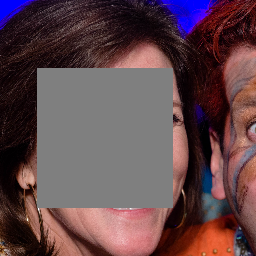

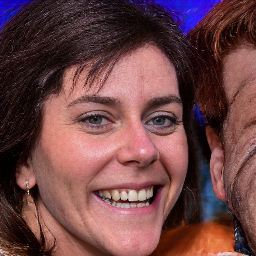

In [20]:
image_completion_with_BERT(idx = 14)